In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Pneumonia Detection from Chest X-Ray Images

Bu projede akciğer filmleri sınıflandırma derin öğrenme modeli ile tahmin edilmeye çalışılıyor.

Projede kullanılan veriler [buradan](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) temin edilmiştir.

<img src="https://i.imgur.com/jZqpV51.png" >

In [2]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
img_path="/kaggle/input/chest-xray-pneumonia/chest_xray/"
labels = ["NORMAL", "PNEUMONIA"]
labels

['NORMAL', 'PNEUMONIA']

In [4]:
def set_df(dir):
    img_list=[]
    label_list=[]
    for label in labels:
        for img_file in os.listdir(dir+label):
            img_list.append(dir+label+"/"+img_file)
            label_list.append(label)
    df=pd.DataFrame({"img":img_list, "label":label_list})
    return df

In [5]:
train=set_df("/kaggle/input/chest-xray-pneumonia/chest_xray/train/")
test=set_df("/kaggle/input/chest-xray-pneumonia/chest_xray/test/")
val=set_df("/kaggle/input/chest-xray-pneumonia/chest_xray/val/")

In [6]:
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
train.head(10)

,img,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


<Axes: xlabel='label', ylabel='count'>

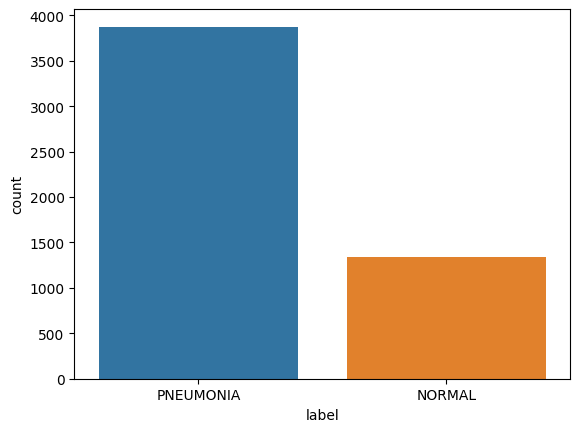

In [7]:
sns.countplot(x=train["label"])

<Axes: xlabel='label', ylabel='count'>

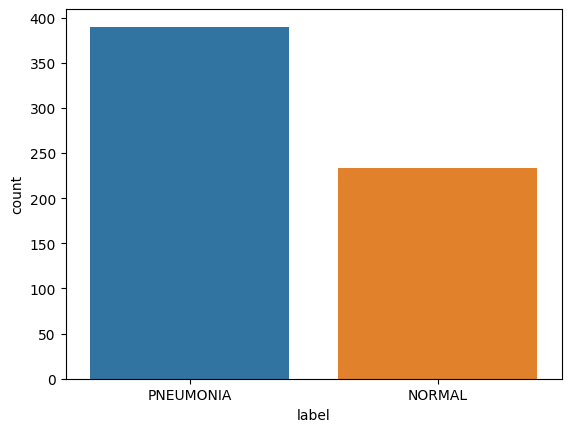

In [8]:
sns.countplot(x=test["label"])

<Axes: xlabel='label', ylabel='count'>

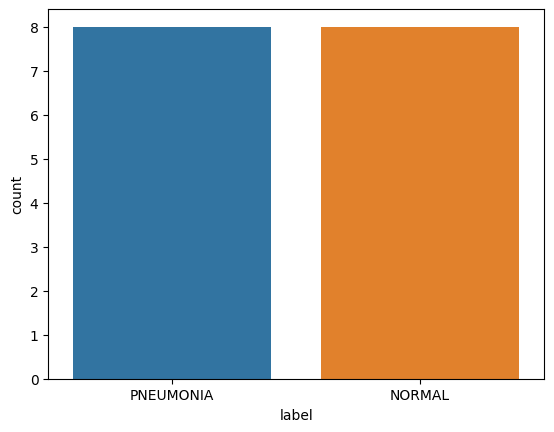

In [9]:
sns.countplot(x=val["label"])

In [10]:
d={"NORMAL":0, "PNEUMONIA":1}
train["encode_label"] = train["label"].map(d)
test["encode_label"] = test["label"].map(d)
val["encode_label"] = val["label"].map(d)

train.head()

,img,label,encode_label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0


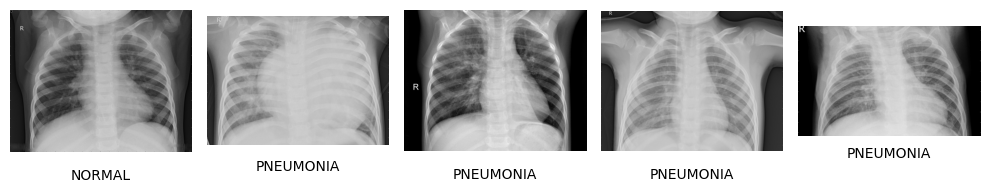

In [11]:
selected_images = train.sample(5)
selected_images = selected_images.reset_index(drop=True)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for i, ax in enumerate(axes.flat):
    image=cv2.imread(str(selected_images["img"][i]))
    ax.imshow(image)
    ax.axis("off")
    ax.text(0.5, -0.2, labels[selected_images["encode_label"][i]], transform=ax.transAxes, ha='center')
plt.tight_layout()
plt.show()

In [12]:
size=224
x_train=[]
for imge in train["img"]:
    img=cv2.imread(str(imge))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img, (size,size))
    img=img/255.0 
    x_train.append(img)

In [13]:
x_test=[]
for imge in test["img"]:
    img=cv2.imread(str(imge))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img, (size,size))
    img=img/255.0 
    x_test.append(img)

In [14]:
x_val=[]
for imge in val["img"]:
    img=cv2.imread(str(imge))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img, (size,size))
    img=img/255.0 
    x_val.append(img)

## Modelleme

In [15]:
x_train=np.array(x_train)
x_test=np.array(x_test)
x_val=np.array(x_val)

y_train=train['encode_label']
y_test=test['encode_label']
y_val=val['encode_label']

In [16]:
train["encode_label"].value_counts()

encode_label
1    3875
0    1341
Name: count, dtype: int64

1


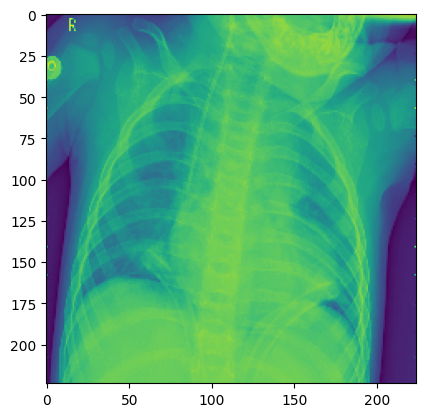

In [17]:
print(y_train[0])
plt.imshow(x_train[0])

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5216, 224, 224), (5216,), (624, 224, 224), (624,))

#### Veri dengesizliğini giderelim

<Axes: xlabel='encode_label', ylabel='count'>

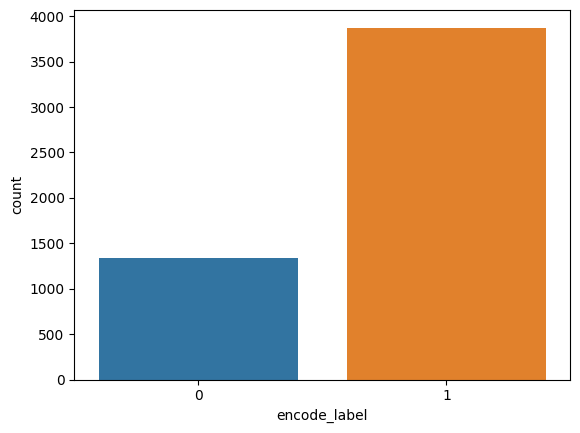

In [19]:
sns.countplot(x=y_train)

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
#x_train, y_train = smote.fit_resample(x_train, y_train)
x_train, y_train = smote.fit_resample(x_train.reshape(5216, 224*224), y_train)
x_train = x_train.reshape(x_train.shape[0], 224, 224)
x_train.shape, y_train.shape

((7750, 224, 224), (7750,))

<Axes: xlabel='encode_label', ylabel='count'>

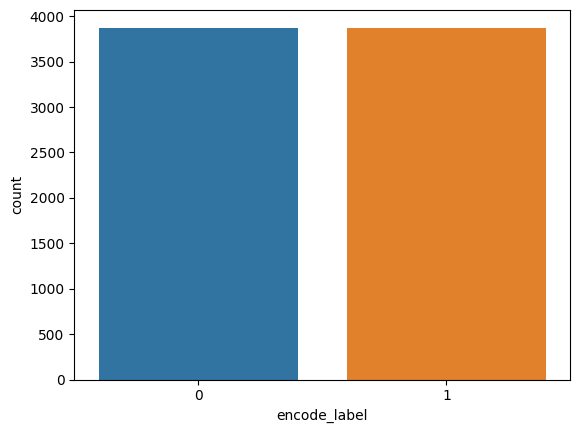

In [21]:
sns.countplot(x=y_train)

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout,BatchNormalization, Reshape
from sklearn.metrics import f1_score, confusion_matrix, classification_report

2024-05-30 13:14:57.255118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 13:14:57.255231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 13:14:57.423312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [52]:
model = Sequential()
model.add(Input(shape=(size, size, 1)))

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
#model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
#model.add(BatchNormalization())

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [58]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32, epochs=4, verbose=1)

Epoch 1/4
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - accuracy: 0.9824 - loss: 0.0513 - val_accuracy: 0.6683 - val_loss: 2.7587
Epoch 2/4
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.9880 - loss: 0.0362 - val_accuracy: 0.7115 - val_loss: 1.8395
Epoch 3/4
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.9880 - loss: 0.0336 - val_accuracy: 0.7468 - val_loss: 1.6695
Epoch 4/4
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.9923 - loss: 0.0272 - val_accuracy: 0.7484 - val_loss: 1.6820


In [59]:
loss, accuracy = model.evaluate(x_test, y_test)
loss, accuracy

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7560 - loss: 1.5308


(1.681990385055542, 0.7483974099159241)

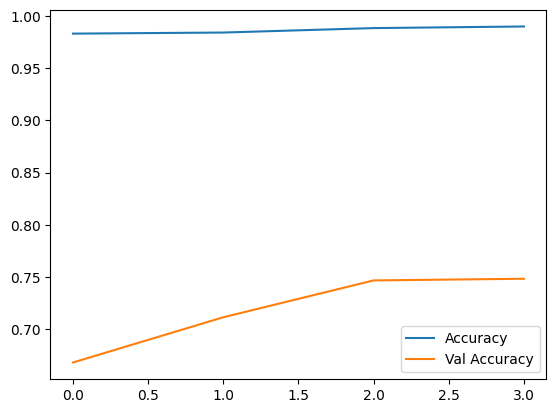

In [60]:
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()

In [61]:
pred = model.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [62]:
confusion_matrix(y_test, np.argmax(pred, axis=1))

array([[ 84, 150],
       [  7, 383]])

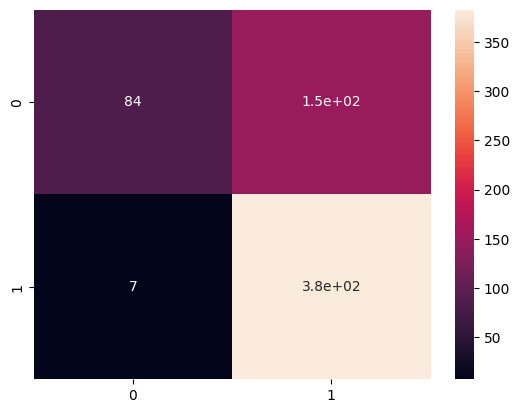

In [63]:
sns.heatmap(confusion_matrix(y_test, np.argmax(pred, axis=1)), annot=True);

In [64]:
print(classification_report(y_test, np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.36      0.52       234
           1       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0


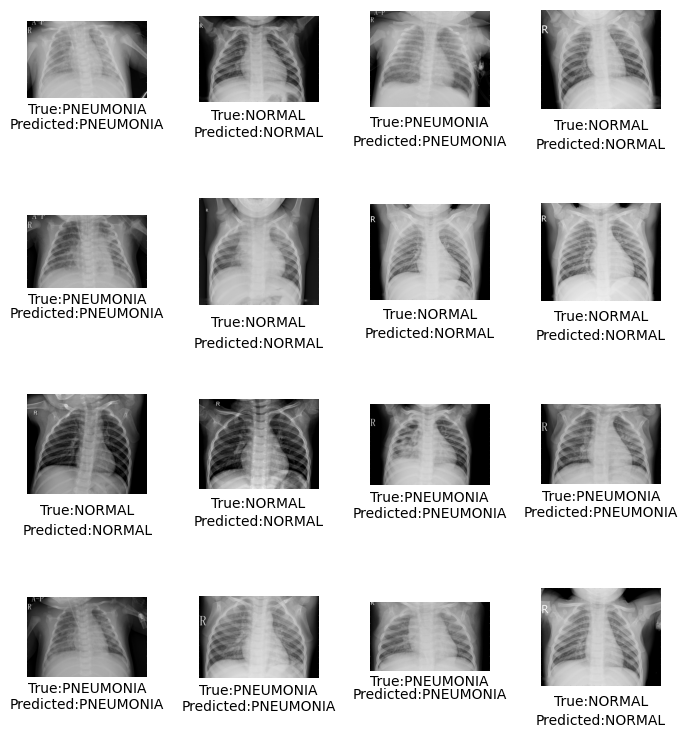

In [65]:
def tahmin(img):
    img=cv2.resize(image, (size,size))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=img/255.0 
    img=np.array(img)
    img=np.expand_dims(img, axis=0)
    thmn=model.predict(img)
    thmn=np.argmax(thmn)
    return thmn

selected_images = val.sample(16)
selected_images = selected_images.reset_index(drop=True)

fig, axes = plt.subplots(4, 4, figsize=(7, 8))

for i, ax in enumerate(axes.flat):
    image=cv2.imread(str(selected_images["img"][i]))
    ax.imshow(image)
    ax.axis("off")
    pred=tahmin(image)
    print(pred)
    ax.text(0.5, -0.2, "True:" + labels[selected_images["encode_label"][i]], transform=ax.transAxes, ha='center')
    ax.text(0.5, -0.4, "Predicted:" + labels[pred], transform=ax.transAxes, ha='center')
plt.tight_layout()
plt.show()

In [66]:
model.save("pneumonia_model.keras")

## Sonuç

Akçiğer filmleri ile eğitilen derin öğrenme modeli zatürre tespitinde yüksek başarı sağlasa da işin içine sağlık girdiği için daha yüksek başarı sağlayacak model geliştirilmesi tavsiye edilmektedir.